# Implementation of CasRNN based on GRU for hyperspectral image segmentation (Huston dataset)

In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [82]:
import os
import numpy as np
import random
from skimage import io as skimage_io
import torch
import torch.utils.data as dataf
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import io
from sklearn.decomposition import PCA
import skimage.filters.rank as sfr
from skimage.morphology import disk
import time
import matplotlib.pyplot as plt
from matplotlib import colors as c
from sklearn.metrics import cohen_kappa_score
import pickle
from matplotlib.pyplot import cm
from sklearn.metrics import confusion_matrix

## Global variables initialization

In [83]:
batchsize = 64 
batchsize_val = 8 

LR = 0.001        
EPOCH = 200
HiddenSize1 = 128  
HiddenSize2 = 256  
GRULayers1 = 1
GRULayers2 = 1
Dropout1 = 0
Dropout2 = 0

TimeStep = 4   

Epoch = 200

## Function declarations

### printImage

In [84]:
# this function prints and saves an image
def printImage(colors, data_to_visualize, path_to_save):
  cmap = c.ListedColormap(colors)
  
  cax = plt.imshow(data_to_visualize,cmap=cmap)
  cbar = plt.colorbar(cax, ticks=np.arange(1, 16, 1), orientation='horizontal')
  cbar.ax.set_xticklabels(['grass healthy', 'grass stressed', 'grass synthetic',
                           'tree', 'soil', 'water', 'residential', 'commercial', 
                           'road', 'highway', 'railway', 'parking lot 1', 
                           'parking lot 2', 'tennis court', 'running track'], rotation=90)

  plt.axis('off')
  # save the image
  plt.savefig(path_to_save, transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.0)

### readData

In [85]:
# this function reads data and reshapes it 
# so that the first two dimensions are special,
# the third is spectral
def readData(data_dir = "/content/drive/MyDrive/landcover/data/"):
  # read data from data_dir
  Data = skimage_io.imread(data_dir + 'CASI_SC_tif.tif')
  TrLabel = skimage_io.imread(data_dir + 'Train_samples.tif')
  TsLabel = skimage_io.imread(data_dir + 'Test_sample.tif')

  print('Data shape: {}'.format(Data.shape))
  print('Train Data shape: {}'.format(TrLabel.shape))
  print('Test Data shape: {}'.format(TsLabel.shape))

  Data = torch.from_numpy(Data.astype(np.float32))
  [L, M, N] = Data.shape
  DataTemp = torch.empty([M, N, L])

  for l in range(L):
    DataTemp[:, :, l] = Data[l, :, :]

  Data = DataTemp
  del DataTemp

  TrLabel = torch.from_numpy(TrLabel)
  TsLabel = torch.from_numpy(TsLabel)


  print('Data shape after reshape: {}'.format(Data.shape))
  return Data, TrLabel, TsLabel

### normalizeData

In [86]:
# this function normalizes given Data by mapping it to zero mean and one std
def normalizeData(data):
  [m, n, l] = data.shape
  for i in range(l):
      mean = torch.mean(data[:, :, i])
      std = torch.std(data[:, :, i])
      Data[:, :, i] = (data[:, :, i] - mean)/std

  print("Mean of the dataset is {}, standard deviation is {}".format(mean, std))
  return data

### constructDataForNetwork

In [87]:
# this function constructs data for network
def constructDataForNetwork(data, trLabel, tsLabel, timeStep = TimeStep):
  # m, n are special dimensions, l is the spectral dimension
  [m, n, l] = data.shape 
  TotalData = torch.reshape(data, [m*n, l])

  TrainDataLabel = torch.reshape(trLabel, [m*n, 1])
  Tr_index, _ = torch.where(TrainDataLabel != 0)
  TrainDataTemp = TotalData[Tr_index, :]
  TrainDataLabel = TrainDataLabel[Tr_index, 0]

  TestDataLabel = torch.reshape(tsLabel, [m*n, 1])
  Ts_index, _ = torch.where(TestDataLabel != 0)
  TestDataTemp = TotalData[Ts_index, :]
  TestDataLabel = TestDataLabel[Ts_index, 0]

  numSeq = l // timeStep
  numTrainSamples = len(TrainDataLabel)
  numTestSamples = len(TestDataLabel)

  TotalData = TotalData.type('torch.FloatTensor') 
  TrainData = torch.empty(numTrainSamples, numSeq, timeStep).type('torch.FloatTensor') 
  TestData = torch.empty(numTestSamples, numSeq, timeStep).type('torch.FloatTensor')

  for i in range(numTrainSamples):
    temp1 = TrainDataTemp[i, :]
    for j in range(timeStep):
        temp2 = temp1[j*numSeq : (j+1)*numSeq]
        TrainData[i, :, j] = temp2

  for i in range(numTestSamples):
    temp1 = TestDataTemp[i, :]
    for j in range(timeStep):
        temp2 = temp1[j*numSeq : (j+1)*numSeq]
        TestData[i, :, j] = temp2

  D = torch.empty(m*n, numSeq, timeStep).type('torch.FloatTensor') 
  for i in range(m*n):
    temp = TotalData[i, :]
    for j in range(timeStep):
        temp2 = temp[j * numSeq : (j+1) * numSeq]
        D[i, :, j] = temp2

  TotalData = D

  TrainDataLabel = TrainDataLabel - 1
  TestDataLabel = TestDataLabel - 1
  TrainDataLabel = TrainDataLabel.long()
  TestDataLabel = TestDataLabel.long()

  print('Training size is {}, testing size is: {}'.format(list(TrainData.shape), list(TestData.shape))) 
  return TrainData, TrainDataLabel, TestData, TestDataLabel, TotalData, m, n, l

### constructDataLoaders

In [88]:
# this function constructs dataloaders
def constructDataLoaders(TrainData, TrainDataLabel, TestData, TestDataLabel):
  num_train_samples = np.int(TrainData.shape[0] * 0.9)
  num_val_samples = TrainData.shape[0] - num_train_samples

  print('Number of training samples {}'.format(num_train_samples))
  print('Number of validation samples {}'.format(num_val_samples))

  train_dataset_full = dataf.TensorDataset(TrainData, TrainDataLabel)
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [num_train_samples, num_val_samples])

  train_loader_full = dataf.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
  train_loader = dataf.DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
  val_loader = dataf.DataLoader(val_dataset, batch_size=batchsize_val, shuffle=True)

  test_dataset = dataf.TensorDataset(TestData, TestDataLabel)
  test_loader = dataf.DataLoader(test_dataset, batch_size=batchsize, shuffle=True)

  Classes = len(torch.unique(TrainDataLabel))
  print('Data has {} classes'.format(Classes))
  return Classes, train_loader_full, train_loader, test_loader, val_loader

### class CasRNN()

In [89]:
# construct the network
class CasRNN(nn.Module):
    def __init__(self, hidden_size1 = HiddenSize1, num_layers1 = GRULayers1, dropout1 = Dropout1, 
                 hidden_size2 = HiddenSize2, num_layers2 = GRULayers2, dropout2 = Dropout2, dropout = 0,
                 classes = 15, timeStep = TimeStep):
        super(CasRNN, self).__init__()

        # the first LSTM layer to reduce redundancy
        self.gru1 = nn.GRU(
            input_size=1,
            hidden_size=hidden_size1,
            num_layers=num_layers1,
            dropout = dropout1, #  if non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        # the second LSTM layer to learn complementary
        self.gru2 = nn.GRU(
            input_size=hidden_size1,
            hidden_size=hidden_size2,
            num_layers=num_layers2,
            dropout = dropout2,  #if non-zero, introduces a Dropout layer on the outputs of each GRU layer except the last layer
            batch_first=True,  # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.timeStep = timeStep

        self.dropout = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_size2, classes)
        
    def forward(self, x):
        input1 = []

        for i in range(self.timeStep):
            temp1 = x[:, :, i].unsqueeze(2)
            r_out1, _ = self.gru1(temp1, None)
            temp2 = r_out1[:, -1, :]
            out1 = temp2.unsqueeze(1)
            input1.append(out1)

        input2 = input1[0]
        for i in range(1, self.timeStep):
            temp2 = input1[i]
            input2 = torch.cat((input2, temp2), 1)
        input2 = self.dropout(input2)
        out4, _ = self.gru2(input2, None)
        output = self.output(out4[:, -1, :])
        return output

print(CasRNN())

CasRNN(
  (gru1): GRU(1, 128, batch_first=True)
  (gru2): GRU(128, 256, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (output): Linear(in_features=256, out_features=15, bias=True)
)


### train

In [90]:
# this function implements the training procedure of CasRNN
def train(epoch, train_loader, val_loader = None, lr=LR, num_layers1=GRULayers1, hidden_size1=HiddenSize1, dropout1=Dropout1,
          num_layers2=GRULayers2, hidden_size2=HiddenSize2, dropout2=Dropout2, dropout = 0,
          timeStep = TimeStep, optimize=False):
  
  # starting time
  start = time.time()
  
  casRNN = CasRNN(hidden_size1=hidden_size1, num_layers1=num_layers1, dropout1=dropout1, 
                  hidden_size2=hidden_size2, num_layers2=num_layers2, dropout2=dropout2,
                  dropout = dropout, timeStep=timeStep)
  casRNN.to(device)
  print(casRNN)

  optimizer = torch.optim.Adam(casRNN.parameters(), lr=lr)
  loss_func = nn.CrossEntropyLoss()

  history = []
  history_train_loss = []
  history_val_loss = []
  history_train_acc = []
  history_val_acc = []

  # training and testing
  for epoch in range(epoch):
      train_loss = 0
      train_acc = 0
      val_loss = 0
      val_acc = 0
      
      casRNN.train()  # in the training phase, we need to use dropout again
      for _, (b_x, b_y) in enumerate(train_loader):  # gives batch data
          b_x = b_x.to(device)
          b_y = b_y.to(device)
          output = casRNN(b_x)  # casRNN output
          loss = loss_func(output, b_y)  # cross entropy loss
          optimizer.zero_grad()  # clear gradients for this training step
          loss.backward()  # backpropagation, compute gradients
          optimizer.step()  # apply gradients

          train_loss += loss.item()
          _, preds = torch.max(output, dim=1)
          train_acc += torch.sum(preds == b_y).item() 

      if optimize == True:
        with torch.no_grad():
          casRNN.eval() # in the testing phase, we don't need to use dropout

          for _, (b_x, b_y) in enumerate(val_loader):
            b_x = b_x.to(device)
            b_y = b_y.to(device)
            output = casRNN(b_x)
            loss = loss_func(output, b_y)
            val_loss += loss.item()

            _, preds = torch.max(output, dim=1)
            val_acc += torch.sum(preds == b_y).item() 

        train_loss = train_loss / (len(train_loader) * batchsize)
        val_loss = val_loss / (len(val_loader) * batchsize_val)
        train_acc = train_acc / (len(train_loader) * batchsize)
        val_acc = val_acc / (len(val_loader) * batchsize_val)

        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        history_train_acc.append(train_acc)
        history_val_acc.append(val_acc)
        print('Epoch: ', epoch, 
              '| train loss: %.4f' % train_loss, 
              '| val loss: %.4f' % val_loss,  
              '| train accuracy: %.4f' % train_acc, 
              '| val accuracy: %.4f' % val_acc)
      else:
        train_loss = train_loss / (len(train_loader) * batchsize)
        train_acc = train_acc / (len(train_loader) * batchsize)
        print('Epoch: ', epoch, '| train loss: %.4f' % train_loss, '| train accuracy: %.4f' % train_acc)
  
  if optimize == True:
    history.append({"timeStep": timeStep, "lr" : lr, "num_layers1" : num_layers1, "hidden_size1" : hidden_size1, "dropout1": dropout1,
                    "num_layers2" : num_layers2, "hidden_size2" : hidden_size2, "dropout2": dropout2, "dropout": dropout,
                    "train_loss" : history_train_loss, "val_loss" : history_val_loss,
                    "train_acc" : history_train_acc, "val_acc" : history_val_acc})

  torch.save(casRNN.state_dict(),
               '/content/drive/MyDrive/landcover/CasRNN/model_weights/net_params_CasRNN_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'
               .format(timeStep, lr, num_layers1, hidden_size1, dropout1, num_layers2, hidden_size2, dropout2, dropout))
  
  # ending time      
  end = time.time()
  return history, end - start

### saveHistory

In [91]:
# this function saves an input into a file
def saveHistory(history, file):
  with open(file, 'wb') as filehandle:
    # store the data as a binary data stream
    pickle.dump(history, filehandle)

### trainForHyperparams

In [92]:
# this function runs the experiments for all combinations of hyperparameters
# provided by a config_hyper_params
def trainForHyperparams(Data, TrLabel, TsLabel, config_hyper_params, history_file, time_file, epoch=Epoch):

  timeStep = config_hyper_params["timeStep"]
  learning_rate = config_hyper_params["learning_rate"]

  gru_num_layers1 = config_hyper_params["gru_num_layers1"]
  gru_hidden_size1 = config_hyper_params["gru_hidden_size1"]
  dropout1 = config_hyper_params["dropout1"]

  gru_num_layers2 = config_hyper_params["gru_num_layers2"]
  gru_hidden_size2 = config_hyper_params["gru_hidden_size2"]
  dropout2 = config_hyper_params["dropout2"]
  dropout = config_hyper_params["dropout"]

  history = []
  time = []

  for step in timeStep:
    # constuct data for the network
    TrainData, TrainDataLabel, TestData, TestDataLabel, TotalData, m , n, l = constructDataForNetwork(
        Data, TrLabel, TsLabel, step)

    # constuct data loaders
    Classes, train_loader_full, train_loader, test_loader, val_loader = constructDataLoaders(
        TrainData, TrainDataLabel, TestData, TestData)


    for lr in learning_rate:
      for layer1 in gru_num_layers1:
        for hidden1 in gru_hidden_size1:
          for d1 in dropout1:
            for layer2 in gru_num_layers2:
              for hidden2 in gru_hidden_size2:
                for d2 in dropout2:
                  for d in dropout:
                    print("Learning rate '{}', gru layers1 '{}', hidden_layers1 '{}', dropout1 '{}',"\
                    "gru layers2 '{}', hidden_layers2 '{}', dropout2 '{}', timeStep '{}', dropout {}".format(
                        lr, layer1, hidden1, d1, layer2, hidden2, d2, step, d))
                    h, t = train(epoch, train_loader, val_loader, lr, layer1, hidden1, d1,
                              layer2, hidden2, d2, d, step, True)
                    history.append(h)
                    time.append({"timeStep": step, "lr": lr, "gru_num_layers1": layer1, "gru_hidden_size1": hidden1 , "dropout1": d1,
                              "gru_num_layers2": layer2, "gru_hidden_size2": hidden2 , "dropout2": d2, "dropout":d, "time": t})
  # write data from training experiment to a file as a binary data
  saveHistory(history, history_file)
  saveHistory(time, time_file)
  return history, time, TestData, TestDataLabel, TotalData, Classes

### readHistory

In [93]:
# this function reads data from a binary file
def readHistory(history_file):
  with open(history_file, 'rb') as filehandle:
    # read data as binary data stream
    history_loaded = pickle.load(filehandle)
  return history_loaded

### plotLosses 

In [94]:
# this functions expects a dictionary with the key words
# "lr", "num_layers", "hidden_size", "train_loss", "val_loss", "train_acc", "val_acc"
# their values should be an array of the same size
# this data is interpreted as training data and visiualised

def plotLosses(history_item, folder, epoch):
    timeStep = history_item["timeStep"]
    lr = history_item["lr"]

    num_layers1 = history_item["num_layers1"]
    hidden_size1 = history_item["hidden_size1"]
    dropout1 = history_item["dropout1"]

    num_layers2 = history_item["num_layers2"]
    hidden_size2 = history_item["hidden_size2"]
    dropout2 = history_item["dropout2"]

    train_losses = history_item['train_loss']
    val_losses = history_item['val_loss']

    train_acc = history_item['train_acc']
    val_acc = history_item['val_acc']

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Learning rate "{}", GRU layers 1. "{}", hidden size 1. "{}", dropout 1. "{}",\
    GRU layers 2. "{}", hidden size 2. "{}", dropout 2. "{}", timeStep "{}"'.format(lr,
                                                               num_layers1,
                                                               hidden_size1,
                                                               dropout1,
                                                               num_layers2,
                                                               hidden_size2,
                                                               dropout2,
                                                               timeStep))
    fig.tight_layout(pad=3.0) # adjust distance between subplots
    plt.subplots_adjust(top=0.8) # adjust distance between subplots and title


    ax1.plot(train_losses, '-b', label = 'Training')
    ax1.plot(val_losses, '-r', label = 'Validation')
    ax1.set_title('Loss vs. epoch')
    ax1.set(xlabel='Epoch', ylabel='Loss')
    #ax1.set_yscale('log')
    ax1.set_xticks(np.arange(start=0, stop=epoch + 1, step=epoch / 4))
    ax1.grid()
    ax1.legend(shadow=True, fancybox=True)
    ax1.set_xlim([0, epoch])

    

    ax2.plot(train_acc, '-b', label = 'Training')
    ax2.plot(val_acc, '-r', label = 'Validation')
    ax2.set_title('Overall accuracy vs. epoch')
    ax2.set(xlabel='Epoch', ylabel='Overall accuracy')
    ax2.set_xticks(np.arange(start=0, stop=epoch + 1, step=epoch / 4))
    ax2.grid()
    ax2.legend(shadow=True, fancybox=True)
    ax2.set_xlim([0, epoch])
    ax2.set_ylim([0, 1])
    ax2.set_yticks(np.arange(start=0, stop=1.1, step=0.1))

    plt.savefig("{}_CasRNN_{}_{}_{}_{}_{}_{}_{}_{}.jpeg".format(folder, lr, 
                                                         num_layers1, hidden_size1, dropout1,
                                                         num_layers2, hidden_size2, dropout2,
                                                         timeStep),
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=0.5)

    plt.pause(0.05)

### getDataForTimeSteps

In [95]:
# this function gathers data to plot sub-sequence number vs. overall accuracy
def getDataForTimeSteps(history, historyForTimeSteps = [], epoch = Epoch):
  # extract data to visualize
  timeSteps = [2, 4, 8, 12, 18]

  for i in range(len(history)):
    
    h = history[i][0]
    hidden_size1 =  h['hidden_size1']
    hidden_size2 =  h['hidden_size2']
    val_acc = h['val_acc'][epoch - 1]

    parameters = 'hidden_size1: {:d}, hidden_size2: {:d}'.format(hidden_size1, hidden_size2)
    result = next(((i,d) for i,d in enumerate(historyForTimeSteps) if parameters  in d), False)
    if (result == False):
      historyForTimeSteps.append({parameters: [val_acc]})
    else:
      historyForTimeSteps[result[0]][parameters].append(val_acc)

  return timeSteps, historyForTimeSteps


### plotTimeSteps

In [96]:
# this function plots sub-sequence number vs. overall accuracy
def plotTimeSteps(timeSteps, historyForTimeSteps, folder):
  num = 6
  for i in range(len(historyForTimeSteps) // num):
    for j in range(num):
      h = historyForTimeSteps[num * i + j]
      params = list(h.keys())[0]
      accuracy = h.get(params)
      plt.plot(timeSteps, accuracy, '-o', label = params)
 
    plt.grid()
  
    plt.title('Sub-sequence number vs. overall accuracy')
    plt.xlabel('Sub-sequence number')
    plt.xticks(np.arange(start=timeSteps[0], stop=timeSteps[len(timeSteps)-1] + 1, step=1))
    plt.ylabel('Overall accuracy')
    plt.yticks(np.arange(start=0.65, stop=1.01, step=0.05))
    plt.legend(loc='upper right', bbox_to_anchor=(1.70, 1.02))

    plt.savefig("{}CasRNN_{}_{}.jpeg".format(folder, params, i),
                transparent=True, dpi=1000, bbox_inches="tight", pad_inches=2.0)
    plt.show()
    plt.pause(0.05)
  


### plotHistory

In [97]:
# this function plots the training experiments results
def plotHistory(history, config, folder, epoch = Epoch):
  timeStep = config["timeStep"]
  learning_rate = config["learning_rate"]

  gru_num_layers1 = config["gru_num_layers1"]
  gru_hidden_size1 = config["gru_hidden_size1"]
  dropout1 = config["dropout1"]

  gru_num_layers2 = config["gru_num_layers2"]
  gru_hidden_size2 = config["gru_hidden_size2"]
  dropout2 = config["dropout2"]

  dropout = config["dropout"]

  i = 0
  for lr in learning_rate:
    for layer1 in gru_num_layers1:
      for hidden1 in gru_hidden_size1:
        for d1 in dropout1:
          for layer2 in gru_num_layers2:
            for hidden2 in gru_hidden_size2:
              for d2 in dropout2:
                for step in timeStep:
                  for d in dropout:
                    print("Learning rate {}, gru layers1 {}, hidden_layers1 {}, dropout1 {},"\
                          "gru layers2 {}, hidden_layers2 {}, dropout2 {}, dropout {}, timeStep {}".format(
                              lr, layer1, hidden1, d1, layer2, hidden2, d2, d, step))
                    plotLosses(history[i][0], folder, epoch)
                    i = i + 1

### predictData

In [98]:
# this function applies model on the second parameter
def predictData(model, dataToPredict, numDataSamples):
  predictions = torch.empty(numDataSamples)
  number = numDataSamples // 5000

  for i in range(number):
    temp = dataToPredict[i*5000 : (i+1)*5000, :, :]
    temp = temp.to(device)
    temp2 = model(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    predictions[i*5000:(i+1)*5000] = temp3.cpu()
    del temp, temp2, temp3

  if (i+1)*5000 < numDataSamples:
    temp = dataToPredict[(i+1)*5000 : numDataSamples, :, :]
    temp = temp.to(device)
    temp2 = model(temp)
    temp3 = torch.max(temp2, 1)[1].squeeze()
    predictions[(i+1)*5000 : numDataSamples] = temp3.cpu()
    del temp, temp2, temp3

  predictions = predictions.type('torch.LongTensor')
  return predictions

### computeOverallAccuracy

In [99]:
# this function computes overall accuracy given prediction and the labels
def computeOverallAccuracy(pred_y, testDataLabel):
  OA = torch.sum(pred_y == testDataLabel).type(torch.FloatTensor) / testDataLabel.size(0)
  return OA

### computeAccuracyForEachClass

In [100]:
# this function computes the accuracy for each class given the predictions
# as the first parameter, labels as the second parameter
# and the number of classes as the third parameter
def computeAccuracyForEachClass(pred_y, testDataLabel, numClasses):
  right = torch.zeros(numClasses)
  sum = torch.zeros(numClasses)

  for j in range(len(TestDataLabel)):
    c = TestDataLabel[j]
    sum[c] += 1
    if pred_y[j] == c:
      right[c] += 1

  return (right/sum).type(torch.FloatTensor)

### computeAvarageAccuracy

In [101]:
# this function computes average accuracy given the predictions
# as the first parameter, labels as the second parameter
# and the number of classes as the third parameter
def computeAvarageAccuracy(pred_y, testDataLabel, numClasses):
  eachAcc = computeAccuracyForEachClass(pred_y, testDataLabel, numClasses)
  return torch.sum(eachAcc) / numClasses

In [102]:
# this function plots a given confustion matirix
# this implemenation was take from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          savePath,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #cbar = plt.colorbar()
    #cbar.ax.set_xticklabels([0, 0.2, 0.5, 0.7, 1])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n overall accuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(savePath,
                transparent=True, dpi=300, bbox_inches="tight", pad_inches=5.0)
    plt.show()

## Tuning the hyperparameters of the model

In [109]:
# use GPU for all further computations if it is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("You are working on {}".format(device))

You are working on cuda:0


In [110]:
# read data
Data, TrLabel, TsLabel = readData()

Data shape: (144, 349, 1905)
Train Data shape: (349, 1905)
Test Data shape: (349, 1905)
Data shape after reshape: torch.Size([349, 1905, 144])


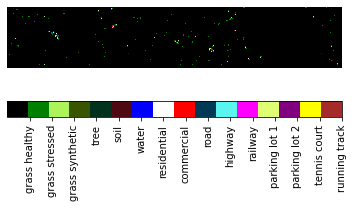

In [ ]:
# visualize the training sample and save it
printImage(
    ["black", "green", "#AEF359", "#395500", "#013220", "#4f0a11",  "blue", "white", "red",
     "#003955", "#5bf5f0", "magenta", "#deff73", "purple", "yellow", "brown"],
    TrLabel,
    '/content/drive/MyDrive/landcover/train.tif')

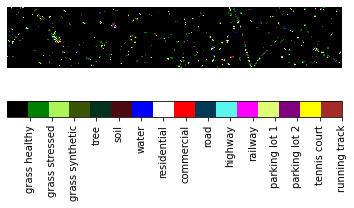

In [ ]:
# visualize the test sample and save it
printImage(
    ["black", "green", "#AEF359", "#395500", "#013220", "#4f0a11",  "blue", "white", "red",
     "#003955", "#5bf5f0", "magenta", "#deff73", "purple", "yellow", "brown"],
    TsLabel,
    '/content/drive/MyDrive/landcover/est.tif')

In [111]:
# normalize data
Data = normalizeData(Data)

Mean of the dataset is 6787.30517578125, standard deviation is 2853.2119140625


In [112]:
# define hyperparameters which you want to train with
hyper_config = {
    "timeStep" : [12],
    "learning_rate" : [0.001],
    "gru_num_layers1" : [1],
    "gru_hidden_size1" : [256],
    "dropout1" : [0],
    "gru_num_layers2" : [1],
    "gru_hidden_size2" : [384],
    "dropout2" : [0],
    "dropout" : [0, 0.3, 0.5, 0.7],
}

In [55]:
# define a path to the files where the training experiments are saved
history_file = '/content/drive/MyDrive/landcover/CasRNN/history/dropouts'
time_file = "/content/drive/MyDrive/landcover/CasRNN/time/dropouts"

In [113]:
# train with the defined above parameters
history, times, TestData, TestDataLabel, TotalData, Classes = trainForHyperparams(Data,
                                                                                  TrLabel,
                                                                                  TsLabel,
                                                                                  hyper_config,
                                                                                  history_file,
                                                                                  time_file)

Training size is [2832, 12, 12], testing size is: [12197, 12, 12]
Number of training samples 2548
Number of validation samples 284
Data has 15 classes
Learning rate '0.001', gru layers1 '1', hidden_layers1 '256', dropout1 '0',gru layers2 '1', hidden_layers2 '384', dropout2 '0', timeStep '12', dropout 0
CasRNN(
  (gru1): GRU(1, 256, batch_first=True)
  (gru2): GRU(256, 384, batch_first=True)
  (dropout): Dropout(p=0, inplace=False)
  (output): Linear(in_features=384, out_features=15, bias=True)
)
Epoch:  0 | train loss: 0.0313 | val loss: 0.1923 | train accuracy: 0.3105 | val accuracy: 0.4340
Epoch:  1 | train loss: 0.0191 | val loss: 0.1307 | train accuracy: 0.5855 | val accuracy: 0.6354
Epoch:  2 | train loss: 0.0148 | val loss: 0.1088 | train accuracy: 0.6652 | val accuracy: 0.6910
Epoch:  3 | train loss: 0.0120 | val loss: 0.0851 | train accuracy: 0.7246 | val accuracy: 0.7500
Epoch:  4 | train loss: 0.0106 | val loss: 0.0829 | train accuracy: 0.7543 | val accuracy: 0.7639
Epoch:  5

In [56]:
# load the experiments history that you want to plot
history_loaded = readHistory(history_file)
times_loaded = readHistory(time_file)

In [ ]:
folderForLossesPlots= "/content/drive/MyDrive/landcover/CasRNN/hyper_params/dropouts/dropouts_"

Learning rate 0.001, gru layers1 1, hidden_layers1 256, dropout1 0,gru layers2 1, hidden_layers2 384, dropout2 0, dropout 0, timeStep 12


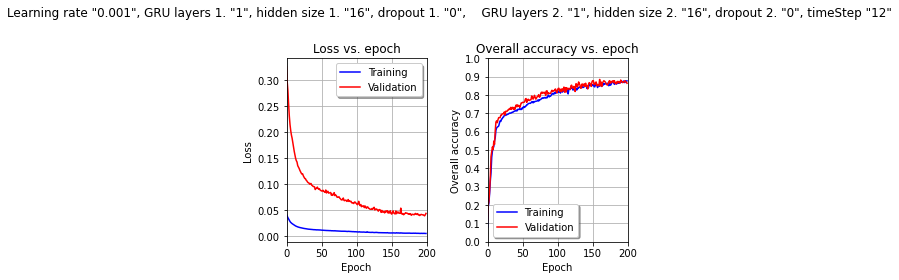

Learning rate 0.001, gru layers1 1, hidden_layers1 256, dropout1 0,gru layers2 1, hidden_layers2 384, dropout2 0, dropout 0.3, timeStep 12


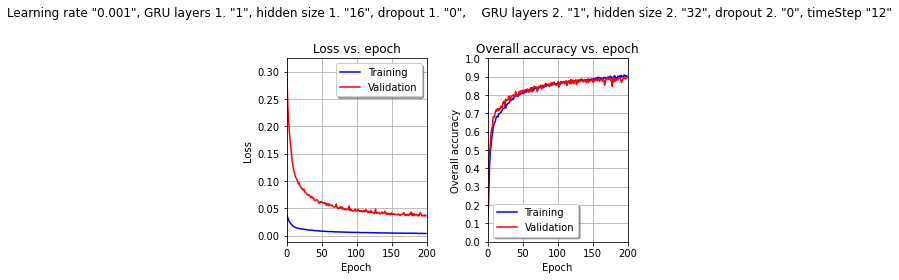

Learning rate 0.001, gru layers1 1, hidden_layers1 256, dropout1 0,gru layers2 1, hidden_layers2 384, dropout2 0, dropout 0.5, timeStep 12


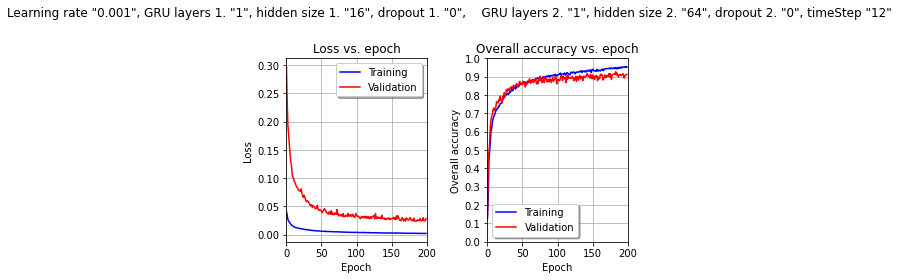

Learning rate 0.001, gru layers1 1, hidden_layers1 256, dropout1 0,gru layers2 1, hidden_layers2 384, dropout2 0, dropout 0.7, timeStep 12


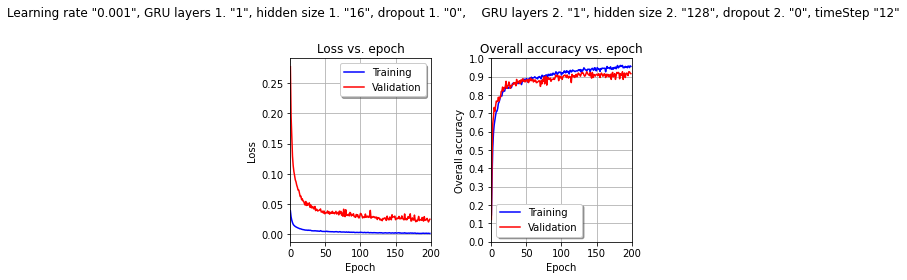

In [ ]:
# plot the training experiments to choose the best hyperparameters
plotHistory(history_loaded_step12, hyper_config , folderForLossesPlots)

In [105]:
# extract data to visualize the "validation accuracy vs. sub-sequence number"
historyForTimeSteps = readHistory('/content/drive/MyDrive/landcover/CasRNN/history/historyForTimeSteps')
timeSteps = [2, 4, 8, 12, 16]

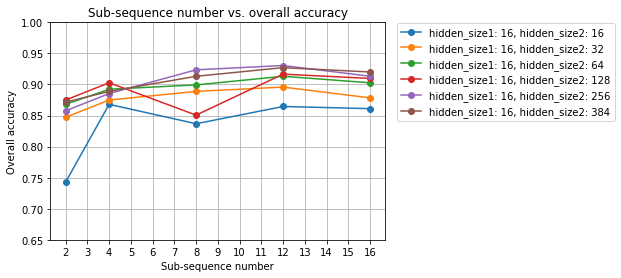

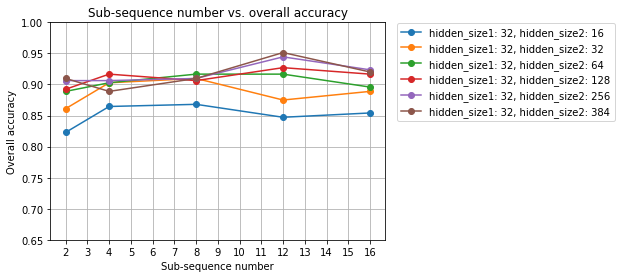

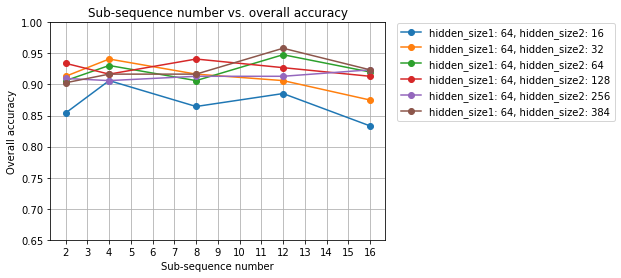

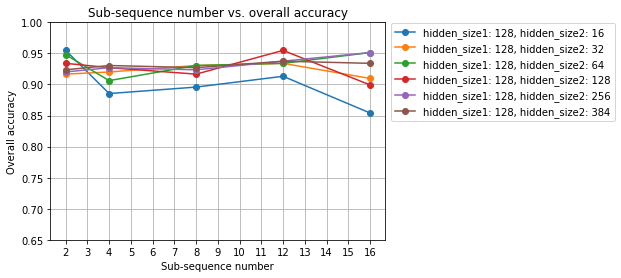

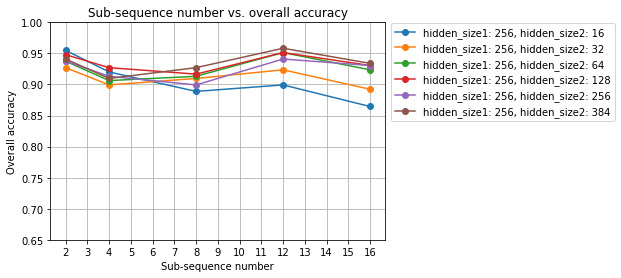

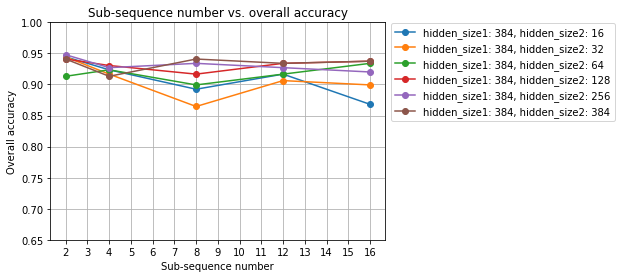

In [107]:
# plot sub-sequence number vs overall. accuracy
plotTimeSteps(timeSteps, historyForTimeSteps, '/content/drive/MyDrive/landcover/CasRNN/hyper_params/timeStep')

## Evaluation of the model on the test data

In [45]:
# choose the best hyperparameters from the analysis of the training experiments 
# perfomed on the validation dataset
best_lr = 0.001
best_num_layers1 = 1
best_hidden_size1 = 256
best_dropout1 = 0
best_num_layers2 = 1
best_hidden_size2 =384
best_dropout2 = 0
best_timeStep = 12
best_dropout = 0

In [58]:
# time of training for the model with the best hyperparameters
for t in times_loaded:
  if t["lr"] == best_lr and t["gru_num_layers1"] == best_num_layers1 and \
  t["gru_hidden_size1"] == best_hidden_size1 and t["dropout1"] == best_dropout1 and \
  t["gru_num_layers2"] == best_num_layers2 and t["gru_hidden_size2"] == best_hidden_size2 \
  and t["dropout2"] == best_dropout2 and t["timeStep"] == best_timeStep:
    print("Training time is {}".format(t["time"]))

Training time is 308.00756549835205


In [46]:
# load the model with the chosen parameters
casRNN = CasRNN(hidden_size1 = best_hidden_size1, num_layers1 = best_num_layers1, dropout1 = best_dropout1,
                hidden_size2 = best_hidden_size2, num_layers2 = best_num_layers2, dropout2 = best_dropout2,
                dropout=best_dropout,
                timeStep = best_timeStep)

In [47]:
# count the number of trainable parameters
params = 0
for p in casRNN.parameters():
  if p.requires_grad:
    params += p.numel()
print("The number of trainable parameters in the model is {}".format(params))

The number of trainable parameters in the model is 2226063


In [48]:
# load the weights from the training experiment with the best results
casRNN.to(device)
casRNN.eval()

casRNN.load_state_dict(torch.load('/content/drive/MyDrive/landcover/CasRNN/model_weights/net_params_CasRNN_{}_{}_{}_{}_{}_{}_{}_{}_{}.pkl'.format(
    best_timeStep, best_lr, best_num_layers1, best_hidden_size1, best_dropout1, best_num_layers2, best_hidden_size2, best_dropout2, best_dropout)))

<All keys matched successfully>

In [49]:
 # constuct data for the network
TrainData, TrainDataLabel, TestData, TestDataLabel, TotalData, m , n, l = constructDataForNetwork(
        Data, TrLabel, TsLabel, best_timeStep)

# constuct data loaders
Classes, train_loader_full, train_loader, test_loader, val_loader = constructDataLoaders(
        TrainData, TrainDataLabel, TestData, TestData)

Training size is [2832, 12, 12], testing size is: [12197, 12, 12]
Number of training samples 2548
Number of validation samples 284
Data has 15 classes


In [50]:
# apply a trained model on the test data and measure testing time
start_y = time.time()
pred_y = predictData(casRNN, TestData, len(TestDataLabel))
end_y = time.time()
time_y = end_y - start_y

print("Testing time is {} sec".format(time_y))

Testing time is 0.8004336357116699 sec


In [ ]:
# compute overall accuracy
compute overall accuracy
OA = computeOverallAccuracy(pred_y, TestDataLabel)
print('Overall accuracy is: {}'.format(OA.data.cpu().numpy()))

Overall accuracy is: 0.8090513944625854


In [ ]:
# compute accuracy for each class
EachAcc = computeAccuracyForEachClass(pred_y, TestDataLabel, Classes)
print('Accuracies for each class are \n\n{}'.format(EachAcc.data.cpu().numpy()))

Accuracies for each class are 

[0.80151945 0.97462404 1.         0.9895833  0.97159094 0.9440559
 0.7919776  0.46818614 0.7601511  0.6177606  0.65844405 0.5552353
 0.5929825  1.         0.987315  ]


In [51]:
# compute average accuracy
AA = computeAvarageAccuracy(pred_y, TestDataLabel, Classes)
print('Avarage accuracy is: {}'.format(AA.data.cpu().numpy()))

Avarage accuracy is: 0.8385207056999207


In [52]:
# compute cohen_score
cohen_score = cohen_kappa_score(pred_y, TestDataLabel)
print('Cohen\'s kappa is: {}'.format(cohen_score))

Cohen's kappa is: 0.7927932793769181


In [53]:
# apply a trained model on all data and measure time
start_all = time.time()
pred_all = predictData(casRNN, TotalData, m*n)
end_all = time.time()
pred_all = torch.reshape(pred_all, (m, n)) + 1

In [54]:
# efficiecy (pixel per second)
pixel_for_sec = (m * n) / (end_all - start_all)
print("Efficiecy, (pixel per second) {}".format(pixel_for_sec))

Efficiecy, (pixel per second) 16571.453357516282


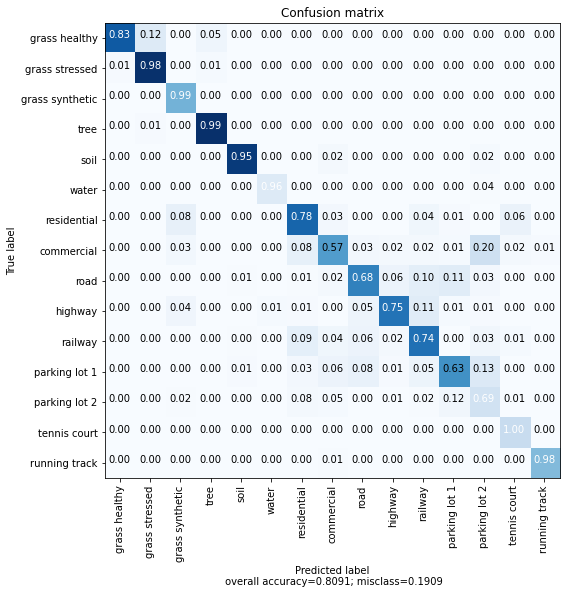

In [ ]:
# produce confusion matrix
cm = confusion_matrix(TestDataLabel, pred_y)
plot_confusion_matrix(cm,['grass healthy', 'grass stressed', 'grass synthetic',
                           'tree', 'soil', 'water', 'residential', 'commercial', 
                           'road', 'highway', 'railway', 'parking lot 1', 
                           'parking lot 2', 'tennis court', 'running track'],
                      '/content/drive/MyDrive/landcover/CasRNN_confusion.png',
                      title='Confusion matrix',
                      cmap=None,normalize=True)

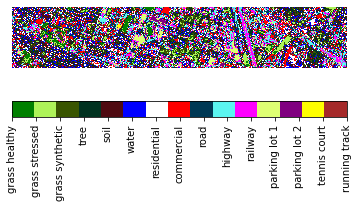

In [ ]:
# create segmantation map and save it
printImage(
    ["green", "#AEF359", "#395500", "#013220", "#4f0a11",  "blue", "white", "red",
     "#003955", "#5bf5f0", "magenta", "#deff73", "purple", "yellow", "brown"],
    pred_all,
    '/content/drive/MyDrive/landcover/segmentation_map_CasRNN.png')